<a href="https://colab.research.google.com/github/ariG23498/NeuralStyleTransfer/blob/master/GradientTapeExp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
import cv2
from tqdm import tqdm

In [2]:
print('tf Version: {}'.format(tf.__version__))
print('Executing eagerly: {}'.format(tf.executing_eagerly()))

tf Version: 2.3.0
Executing eagerly: True


## Dataset

In [3]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 40.68 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [4]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [6]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [7]:
X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)

  8%|▊         | 20/250 [00:00<00:01, 191.56it/s]

(1250, 224, 224, 3) (1250,)


100%|██████████| 250/250 [00:01<00:00, 179.87it/s]


(250, 224, 224, 3) (250,)


## Pretrained VGG16

In [8]:
model = tf.keras.applications.VGG16()
model.summary()

553467904/553467096 [==============================] - 14s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

## block5_pool

In [9]:
layer_name = 'block5_pool'
slice_model = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer(layer_name).output
    )
slice_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [10]:
loss_history = []
white_image = tf.Variable(tf.random.normal(shape=(1,224,224,3)))
X = tf.constant(X_train[np.newaxis,0,:,:,:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3) (1, 224, 224, 3)


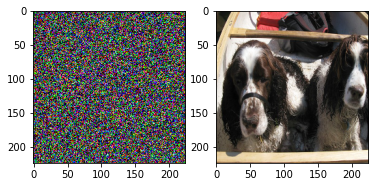

In [11]:
print(white_image.shape, X.shape)
plt.subplot(1,2,1)
plt.imshow(white_image[0])
plt.subplot(1,2,2)
plt.imshow(X[0])

In [12]:
output_img = slice_model(X)
output_img.shape

TensorShape([1, 7, 7, 512])

In [15]:
def train_step():
  with tf.GradientTape() as tape:
    output_white_img = slice_model(white_image)

    loss_value = tf.keras.losses.MSE(output_img, output_white_img)

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, white_image)
  white_image.assign_sub(tf.expand_dims(grads[0],0))

In [17]:
for i in tqdm(range(300)):
  train_step()

100%|██████████| 300/300 [10:08<00:00,  2.03s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


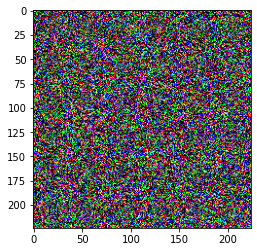

In [18]:
plt.imshow(white_image[0])

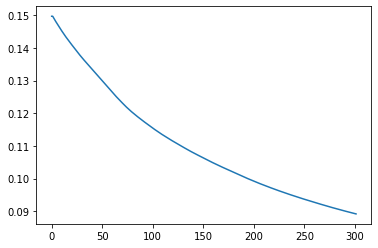

In [19]:
plt.plot(loss_history)

## block4_pool

In [20]:
layer_name = 'block4_pool'
slice_model = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer(layer_name).output
    )
slice_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [21]:
loss_history = []
white_image = tf.Variable(tf.random.normal(shape=(1,224,224,3)))
X = tf.constant(X_train[np.newaxis,0,:,:,:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3) (1, 224, 224, 3)


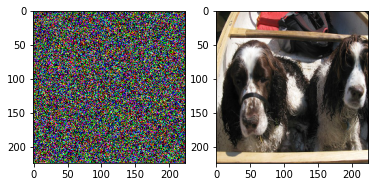

In [22]:
print(white_image.shape, X.shape)
plt.subplot(1,2,1)
plt.imshow(white_image[0])
plt.subplot(1,2,2)
plt.imshow(X[0])

In [23]:
output_img = slice_model(X)
output_img.shape

TensorShape([1, 14, 14, 512])

In [24]:
def train_step():
  with tf.GradientTape() as tape:
    output_white_img = slice_model(white_image)

    loss_value = tf.keras.losses.MSE(output_img, output_white_img)

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, white_image)
  white_image.assign_sub(tf.expand_dims(grads[0],0))

In [26]:
for i in tqdm(range(300)):
  train_step()

100%|██████████| 300/300 [08:57<00:00,  1.79s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


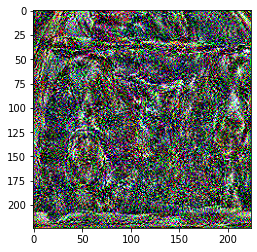

In [27]:
plt.imshow(white_image[0])

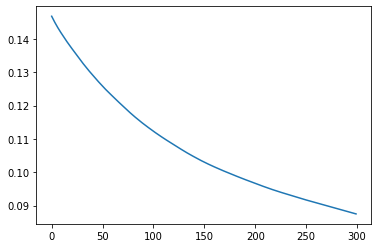

In [ ]:
plt.plot(loss_history)

## block3_pool

In [28]:
layer_name = 'block3_pool'
slice_model = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer(layer_name).output
    )
slice_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [29]:
loss_history = []
white_image = tf.Variable(tf.random.normal(shape=(1,224,224,3)))
X = tf.constant(X_train[np.newaxis,0,:,:,:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3) (1, 224, 224, 3)


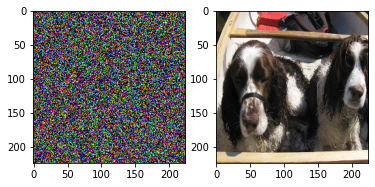

In [30]:
print(white_image.shape, X.shape)
plt.subplot(1,2,1)
plt.imshow(white_image[0])
plt.subplot(1,2,2)
plt.imshow(X[0])

In [31]:
output_img = slice_model(X)
output_img.shape

TensorShape([1, 28, 28, 256])

In [32]:
def train_step():
  with tf.GradientTape() as tape:
    output_white_img = slice_model(white_image)

    loss_value = tf.keras.losses.MSE(output_img, output_white_img)

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, white_image)
  white_image.assign_sub(tf.expand_dims(grads[0],0))

In [33]:
for i in tqdm(range(300)):
  train_step()

100%|██████████| 300/300 [06:13<00:00,  1.25s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


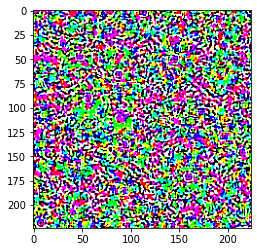

In [34]:
plt.imshow(white_image[0])

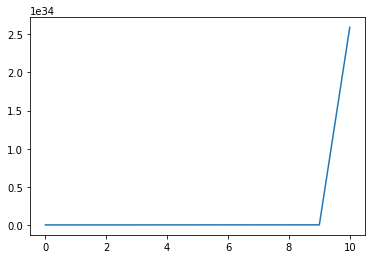

In [35]:
plt.plot(loss_history)

## block2_pool

In [36]:
layer_name = 'block2_pool'
slice_model = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer(layer_name).output
    )
slice_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [37]:
loss_history = []
white_image = tf.Variable(tf.random.normal(shape=(1,224,224,3)))
X = tf.constant(X_train[np.newaxis,0,:,:,:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3) (1, 224, 224, 3)


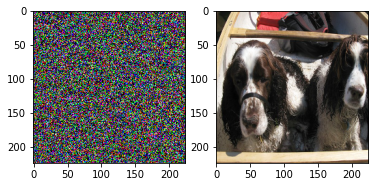

In [38]:
print(white_image.shape, X.shape)
plt.subplot(1,2,1)
plt.imshow(white_image[0])
plt.subplot(1,2,2)
plt.imshow(X[0])

In [39]:
output_img = slice_model(X)
output_img.shape

TensorShape([1, 56, 56, 128])

In [40]:
def train_step():
  with tf.GradientTape() as tape:
    output_white_img = slice_model(white_image)

    loss_value = tf.keras.losses.MSE(output_img, output_white_img)

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, white_image)
  white_image.assign_sub(tf.expand_dims(grads[0],0))

In [41]:
for i in tqdm(range(300)):
  train_step()

100%|██████████| 300/300 [03:36<00:00,  1.39it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


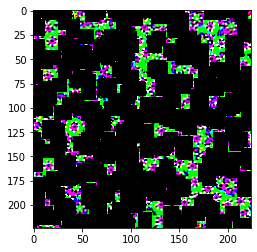

In [42]:
plt.imshow(white_image[0])

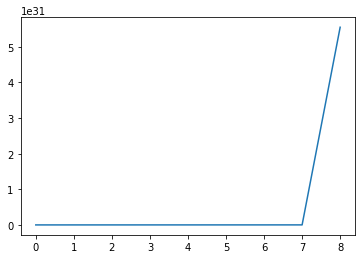

In [44]:
plt.plot(loss_history)

## block1_pool

In [45]:
layer_name = 'block1_pool'
slice_model = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer(layer_name).output
    )
slice_model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


In [46]:
loss_history = []
white_image = tf.Variable(tf.random.normal(shape=(1,224,224,3)))
X = tf.constant(X_train[np.newaxis,0,:,:,:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3) (1, 224, 224, 3)


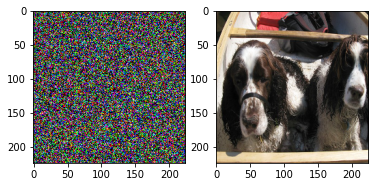

In [47]:
print(white_image.shape, X.shape)
plt.subplot(1,2,1)
plt.imshow(white_image[0])
plt.subplot(1,2,2)
plt.imshow(X[0])

In [48]:
output_img = slice_model(X)
output_img.shape

TensorShape([1, 112, 112, 64])

In [49]:
def train_step():
  with tf.GradientTape() as tape:
    output_white_img = slice_model(white_image)

    loss_value = tf.keras.losses.MSE(output_img, output_white_img)

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, white_image)
  white_image.assign_sub(tf.expand_dims(grads[0],0))

In [50]:
for i in tqdm(range(300)):
  train_step()

  4%|▍         | 13/300 [00:04<01:45,  2.72it/s]/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
100%|██████████| 300/300 [01:47<00:00,  2.78it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


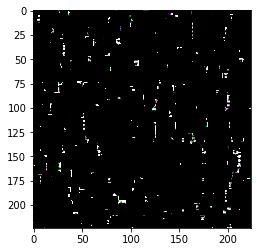

In [51]:
plt.imshow(white_image[0])

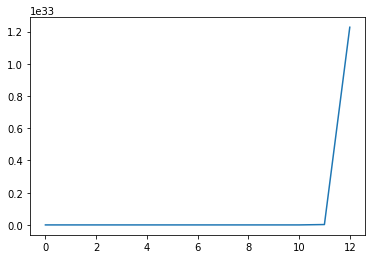

In [52]:
plt.plot(loss_history)